In [ ]:
# model_xgb.py

from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import joblib
from pathlib import Path

# Paths
model_dir = Path('/content/drive/MyDrive/load_type_prediction/fine_tuned_model')
model_dir.mkdir(parents=True, exist_ok=True)

# Load data
df = pd.read_csv('/content/drive/MyDrive/load_type_prediction/processed_data/train_transformed.csv')
X = df.drop(columns=['Load_Type'])
y = df['Load_Type']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_val)
print("🔍 XGBoost Evaluation:")
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))

# Save model
joblib.dump(model, model_dir / 'xgboost_model.pkl')
print("✅ Model saved: xgboost_model.pkl")


Mounted at /content/drive


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:43:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


🔍 XGBoost Evaluation:
[[3128   89   16]
 [ 104 1626   77]
 [  28   67 1278]]
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      3233
           1       0.91      0.90      0.91      1807
           2       0.93      0.93      0.93      1373

    accuracy                           0.94      6413
   macro avg       0.93      0.93      0.93      6413
weighted avg       0.94      0.94      0.94      6413

✅ Model saved: xgboost_model.pkl


In [ ]:
# test_xgboost.py

from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import joblib
from sklearn.metrics import classification_report, confusion_matrix

# Load test data
df_test = pd.read_csv('/content/drive/MyDrive/load_type_prediction/processed_data/test_transformed.csv')
X_test = df_test.drop(columns=['Load_Type'])
y_test = df_test['Load_Type']

# Map labels to integers
label_map = {'Light_Load': 0, 'Medium_Load': 1, 'Maximum_Load': 2}
y_test = y_test.map(label_map)

# Load saved model
model = joblib.load('/content/drive/MyDrive/load_type_prediction/fine_tuned_model/xgboost_model.pkl')

# Predict
y_pred = model.predict(X_test)

# Evaluate
print("🔍 XGBoost Model on Test Set:")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
🔍 XGBoost Model on Test Set:
[[1578   99   68]
 [  33  633   38]
 [  37   30  461]]
              precision    recall  f1-score   support

           0       0.96      0.90      0.93      1745
           1       0.83      0.90      0.86       704
           2       0.81      0.87      0.84       528

    accuracy                           0.90      2977
   macro avg       0.87      0.89      0.88      2977
weighted avg       0.90      0.90      0.90      2977



In [1]:
# model_xgb_tuned.py

from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import joblib
from pathlib import Path
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from scipy.stats import uniform, randint

# === 1. Setup Paths ===
model_dir = Path('/content/drive/MyDrive/load_type_prediction/fine_tuned_model')
model_dir.mkdir(parents=True, exist_ok=True)

# === 2. Load Data ===
df = pd.read_csv('/content/drive/MyDrive/load_type_prediction/processed_data/train_transformed.csv')
X = df.drop(columns=['Load_Type'])
y = df['Load_Type']

# === 3. Stratified Train/Validation Split ===
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# === 4. Define XGBoost and Hyperparameter Search Space ===
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

param_dist = {
    'n_estimators': randint(100, 300),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.2),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'gamma': uniform(0, 5),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0.5, 1)
}

random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=30,
    scoring='f1_weighted',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# === 5. Perform Hyperparameter Tuning ===
random_search.fit(X_train, y_train)

# === 6. Best Model Evaluation ===
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_val)

print("\n🔍 Tuned XGBoost Evaluation on Validation Set:")
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))

print("\n✅ Best Parameters Found:")
print(random_search.best_params_)

# === 7. Save the Best Model ===
joblib.dump(best_model, model_dir / 'xgboost_tuned_model.pkl')
print("✅ Tuned model saved as: xgboost_tuned_model.pkl")


Mounted at /content/drive
Fitting 5 folds for each of 30 candidates, totalling 150 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:35:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



🔍 Tuned XGBoost Evaluation on Validation Set:
[[3139  116   11]
 [  84 1631   83]
 [  37   54 1258]]
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      3266
           1       0.91      0.91      0.91      1798
           2       0.93      0.93      0.93      1349

    accuracy                           0.94      6413
   macro avg       0.93      0.93      0.93      6413
weighted avg       0.94      0.94      0.94      6413


✅ Best Parameters Found:
{'colsample_bytree': np.float64(0.6727299868828402), 'gamma': np.float64(0.9170225492671691), 'learning_rate': np.float64(0.07084844859190755), 'max_depth': 8, 'n_estimators': 188, 'reg_alpha': np.float64(0.2912291401980419), 'reg_lambda': np.float64(1.1118528947223796), 'subsample': np.float64(0.6557975442608167)}
✅ Tuned model saved as: xgboost_tuned_model.pkl


In [2]:
# test_xgboost.py

from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import joblib
from sklearn.metrics import classification_report, confusion_matrix

# Load test data
df_test = pd.read_csv('/content/drive/MyDrive/load_type_prediction/processed_data/test_transformed.csv')
X_test = df_test.drop(columns=['Load_Type'])
y_test = df_test['Load_Type']

# Map labels to integers
label_map = {'Light_Load': 0, 'Medium_Load': 1, 'Maximum_Load': 2}
y_test = y_test.map(label_map)

# Load saved model
model = joblib.load('/content/drive/MyDrive/load_type_prediction/fine_tuned_model/xgboost_tuned_model.pkl')

# Predict
y_pred = model.predict(X_test)

# Evaluate
print("🔍 XGBoost Model on Test Set:")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
🔍 XGBoost Model on Test Set:
[[1546  126   73]
 [  13  649   42]
 [  24   27  477]]
              precision    recall  f1-score   support

           0       0.98      0.89      0.93      1745
           1       0.81      0.92      0.86       704
           2       0.81      0.90      0.85       528

    accuracy                           0.90      2977
   macro avg       0.86      0.90      0.88      2977
weighted avg       0.91      0.90      0.90      2977



In [3]:
pip install shap

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

🔍 SHAP Beeswarm for Class 0: Light_Load


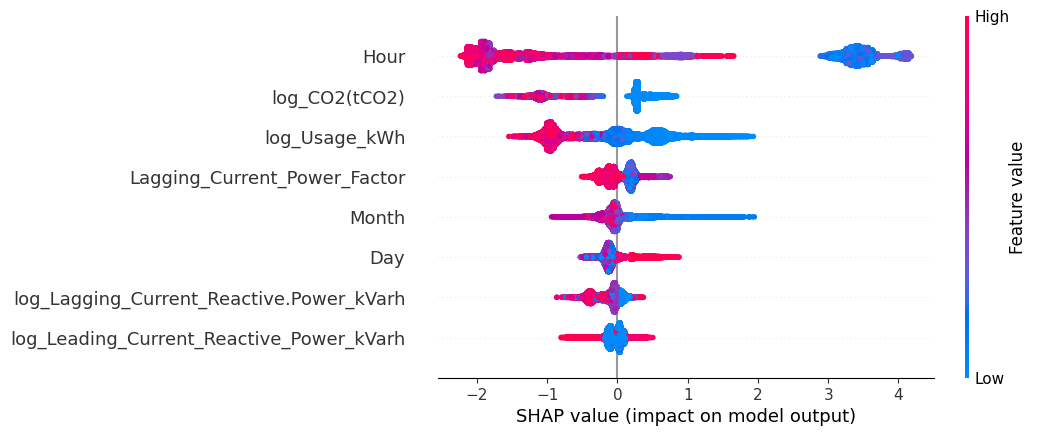


📊 SHAP Bar Plot for Class 0: Light_Load


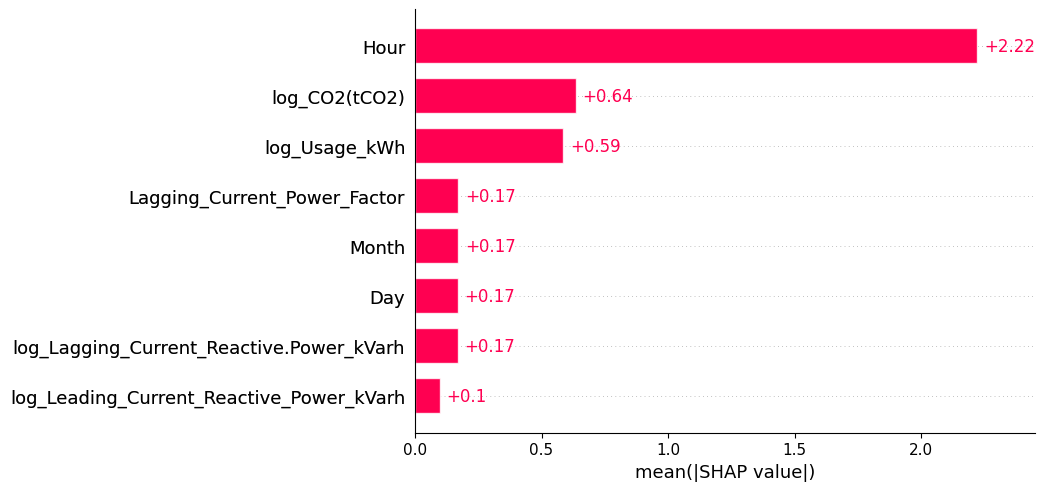


🔍 SHAP Beeswarm for Class 1: Medium_Load


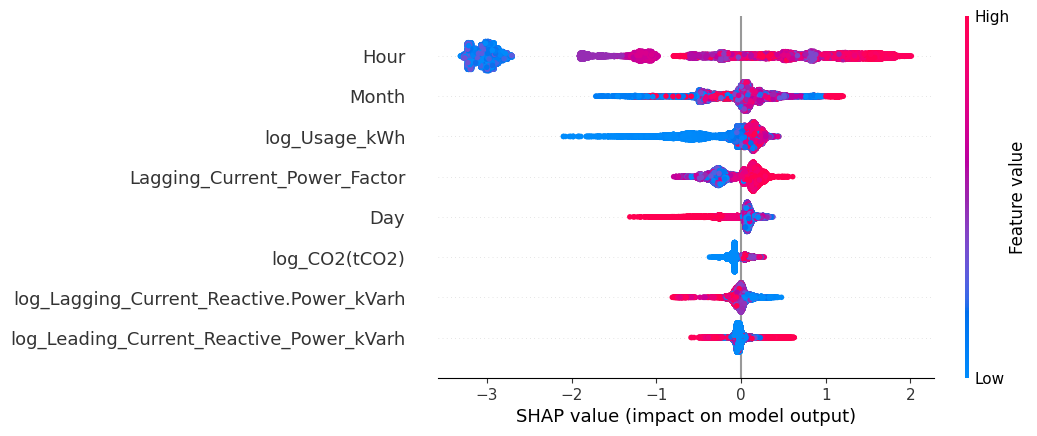


📊 SHAP Bar Plot for Class 1: Medium_Load


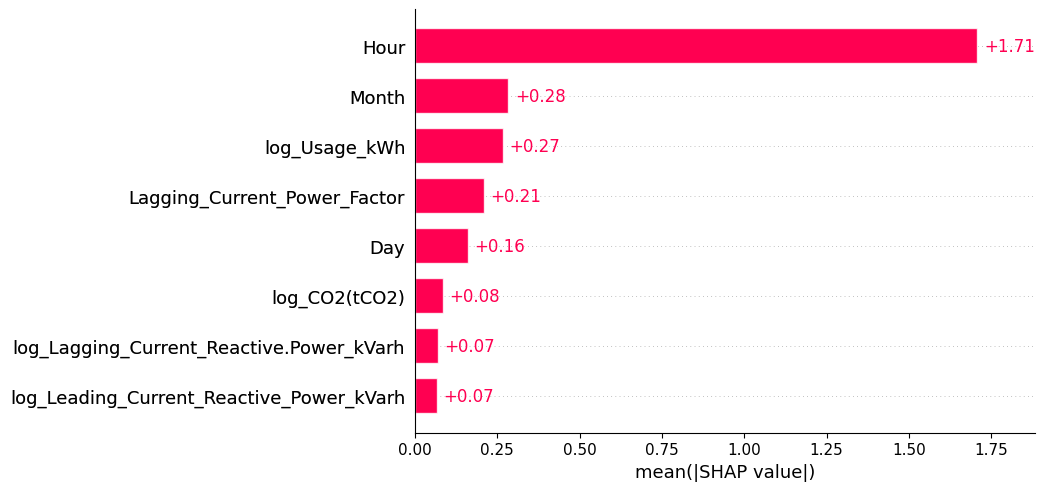


🔍 SHAP Beeswarm for Class 2: Maximum_Load


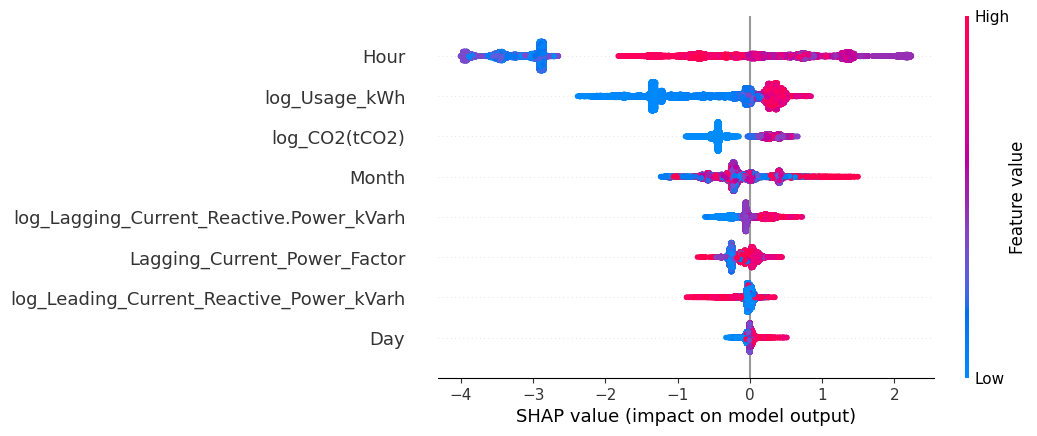


📊 SHAP Bar Plot for Class 2: Maximum_Load


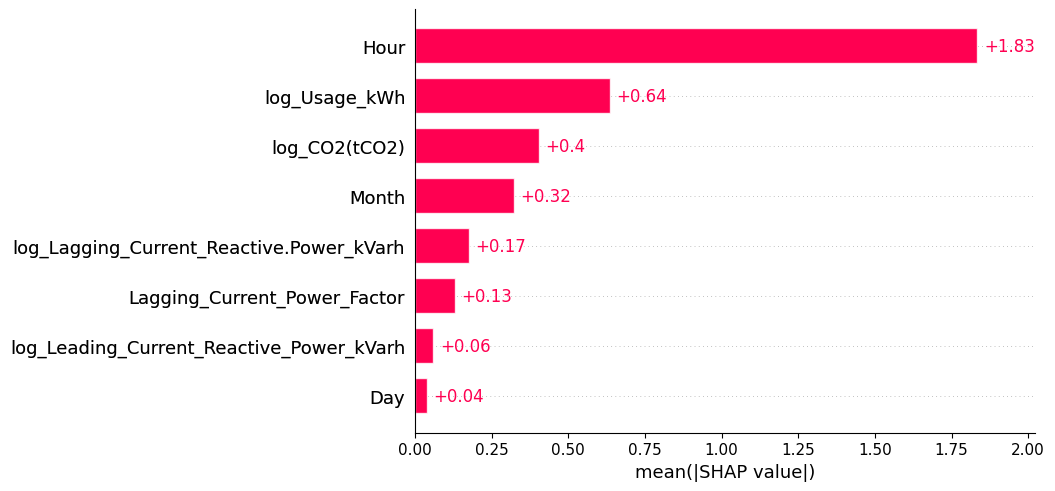

TypeError: In v0.20, force plot now requires the base value as the first parameter! Try shap.plots.force(explainer.expected_value, shap_values) or for multi-output models try shap.plots.force(explainer.expected_value[0], shap_values[..., 0]).

In [6]:
# shap_xgboost_train_explain.py

from google.colab import drive
drive.mount('/content/drive')

import shap
import pandas as pd
import joblib
import matplotlib.pyplot as plt

# === Load Model and Data ===
model = joblib.load('/content/drive/MyDrive/load_type_prediction/fine_tuned_model/xgboost_tuned_model.pkl')
df = pd.read_csv('/content/drive/MyDrive/load_type_prediction/processed_data/train_transformed.csv')
X = df.drop(columns=['Load_Type'])

# === SHAP Initialization ===
explainer = shap.Explainer(model)
shap_values = explainer(X)
class_labels = ['Light_Load', 'Medium_Load', 'Maximum_Load']

# === Smaller Plots
shap.plots._utils.plt.rcParams.update({'figure.figsize': (6, 4)})

# === Beeswarm + Bar plots per class
for i in range(3):
    print(f"\n🔍 SHAP Beeswarm for Class {i}: {class_labels[i]}")
    shap.plots.beeswarm(shap_values[:, :, i], max_display=15)

    print(f"\n📊 SHAP Bar Plot for Class {i}: {class_labels[i]}")
    shap.plots.bar(shap_values[:, :, i], max_display=15)

# === Optional force plot (small)
shap.initjs()
shap.plots.force(shap_values[10])  # adjust index if needed

# === Export SHAP values for Class 0
shap_df = pd.DataFrame(shap_values.values[:, :, 0], columns=X.columns)
shap_df['BaseValue'] = shap_values.base_values[:, 0]
shap_df['PredictedClass'] = model.predict(X)

full_shap = pd.concat([X.reset_index(drop=True), shap_df], axis=1)
full_shap.to_csv('/content/drive/MyDrive/load_type_prediction/processed_data/shap_values_train.csv', index=False)
print("✅ SHAP values (train set) saved to: shap_values_train.csv")


In [ ]:
# === Export SHAP values for train set to CSV ===

# Get base values, shap values, and input features
shap_df_train = pd.DataFrame(
    shap_values.values,
    columns=X.columns
)
shap_df_train['BaseValue'] = shap_values.base_values
shap_df_train['PredictedClass'] = model.predict(X)

# Combine with input features for context
full_shap_train = pd.concat([X.reset_index(drop=True), shap_df_train], axis=1)

# Save to CSV
full_shap_train.to_csv('/content/drive/MyDrive/load_type_prediction/processed_data/shap_values_train.csv', index=False)
print("✅ SHAP values (train set) saved to: shap_values_train.csv")


In [ ]:
# shap_xgboost_test_explain.py

from google.colab import drive
drive.mount('/content/drive')

import shap
import pandas as pd
import joblib
import matplotlib.pyplot as plt

# === Load Model and Test Data ===
model = joblib.load('/content/drive/MyDrive/load_type_prediction/fine_tuned_model/xgboost_tuned_model.pkl')
df = pd.read_csv('/content/drive/MyDrive/load_type_prediction/processed_data/test_transformed.csv')
X = df.drop(columns=['Load_Type'])

# === SHAP Initialization ===
explainer = shap.Explainer(model)
shap_values = explainer(X)
class_labels = ['Light_Load', 'Medium_Load', 'Maximum_Load']

# === Smaller Plots
shap.plots._utils.plt.rcParams.update({'figure.figsize': (6, 4)})

# === Beeswarm + Bar plots per class
for i in range(3):
    print(f"\n🔍 SHAP Beeswarm for Class {i}: {class_labels[i]}")
    shap.plots.beeswarm(shap_values[:, :, i], max_display=15)

    print(f"\n📊 SHAP Bar Plot for Class {i}: {class_labels[i]}")
    shap.plots.bar(shap_values[:, :, i], max_display=15)

# === Optional force plot (small)
shap.initjs()
shap.plots.force(shap_values[5])  # adjust index if needed

# === Export SHAP values for Class 0
shap_df = pd.DataFrame(shap_values.values[:, :, 0], columns=X.columns)
shap_df['BaseValue'] = shap_values.base_values[:, 0]
shap_df['PredictedClass'] = model.predict(X)

full_shap = pd.concat([X.reset_index(drop=True), shap_df], axis=1)
full_shap.to_csv('/content/drive/MyDrive/load_type_prediction/processed_data/shap_values_test.csv', index=False)
print("✅ SHAP values (test set) saved to: shap_values_test.csv")


In [ ]:
# === Export SHAP values for test set to CSV ===

shap_df_test = pd.DataFrame(
    shap_values.values,
    columns=X_test.columns
)
shap_df_test['BaseValue'] = shap_values.base_values
shap_df_test['PredictedClass'] = model.predict(X_test)

# Combine with input features for context
full_shap_test = pd.concat([X_test.reset_index(drop=True), shap_df_test], axis=1)

# Save to CSV
full_shap_test.to_csv('/content/drive/MyDrive/load_type_prediction/processed_data/shap_values_test.csv', index=False)
print("✅ SHAP values (test set) saved to: shap_values_test.csv")
